In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
def parse_csv_file(file_path):
    df = pd.read_csv(file_path)
    return df

def extract_last_values(df, bus_numbers, n_values=855):
    bus_data = {}
    for bus in bus_numbers:
        bus_data[bus] = df[[f'Bus{bus}', 'Label']].values[-n_values:]
    return bus_data

In [ ]:
def glr_cusum(data, mu0, sigma0, h):
    n = len(data)
    g = np.zeros(n)
    for k in range(1, n):
        max_val = -np.inf
        for j in range(1, k+1):
            local_sum = np.sum((data[j-1:k] - mu0)**2)
            quantity = local_sum / (k - j + 1)
            if quantity > max_val:
                max_val = quantity
        g[k] = (1 / (2 * sigma0**2)) * max_val
        if g[k] > h:
            return k, g
    return -1, g
def calculate_mu0_sigma0(data):
  mu0 = np.mean(data)
  sigma0 = np.std(data)
  return mu0, sigma0

In [ ]:
def find_best_threshold(bus_data, thresholds, window_size=50):
    best_thresholds = {}
    for bus, values in tqdm(bus_data.items()):
        data, labels = values[:, 0], values[:, 1]

        best_h = None
        best_score = np.inf
        scaler = StandardScaler()
        # standardized_values = scaler.fit_transform(values.reshape(-1, 1)).flatten()
        standardized_values = standardize_data(data)
        mu0, sigma0 = calculate_mu0_sigma0(standardized_values)
        for h in thresholds:
            detection_delays = []
            false_alarms = 0
            for start in range(0, len(standardized_values) - window_size, window_size):
                window_data = standardized_values[start:start + window_size]
                detection_time, _ = glr_cusum(window_data, mu0, sigma0, h)

                if detection_time != -1:
                    detection_delays.append(detection_time)
                    if np.all(labels[start:start + window_size] == 0):
                        false_alarms += 1

            avg_delay = np.mean(detection_delays) if detection_delays else np.inf
            false_alarm_rate = false_alarms / (len(data) / window_size)
            score = avg_delay + false_alarm_rate * 1000  # 权衡检测延迟和误报率
            # print(score)
            if score < best_score:
                best_score = score
                best_h = h
        print(avg_delay)
        best_thresholds[bus] = best_h
    return best_thresholds
def standardize_data(values):
    """ 标准化给定的numpy数组或Pandas序列 """
    mean = np.mean(values)
    std = np.std(values)
    standardized_values = (values - mean) / std
    return standardized_values
file_path = '/content/drive/MyDrive/ColabNotebooks/MSCProject/DataSet/LMPs/A_LMPFreq3_Labeled.csv'
df = parse_csv_file(file_path)

# 提取巴士数据
bus_numbers = [115, 116, 117, 118, 119, 121, 135, 139]
# bus_numbers = [115, 116, 117, 118, 119, 121,122,123,124,125,126,127,128,129,130,131,132,133,134, 135, 139]
bus_data = extract_last_values(df, bus_numbers)
# 设定不同的阈值
thresholds = np.arange(1, 10, 0.2)

best_thresholds = find_best_threshold(bus_data, thresholds)

print("Best thresholds for each bus:")
for bus, h in best_thresholds.items():
    print(f"Bus {bus}: h = {h}")


 12%|█▎        | 1/8 [00:09<01:09,  9.90s/it]

inf


 25%|██▌       | 2/8 [00:16<00:48,  8.07s/it]

inf


 38%|███▊      | 3/8 [00:23<00:37,  7.49s/it]

inf


 50%|█████     | 4/8 [00:31<00:30,  7.52s/it]

inf


 62%|██████▎   | 5/8 [00:38<00:22,  7.37s/it]

inf


 75%|███████▌  | 6/8 [00:42<00:12,  6.21s/it]

22.5


 88%|████████▊ | 7/8 [00:49<00:06,  6.54s/it]

inf


100%|██████████| 8/8 [00:54<00:00,  6.86s/it]

inf
Best thresholds for each bus:
Bus 115: h = 2.1999999999999997
Bus 116: h = 6.199999999999999
Bus 117: h = 2.3999999999999995
Bus 118: h = 1.7999999999999998
Bus 119: h = 2.1999999999999997
Bus 121: h = 8.399999999999999
Bus 135: h = 4.799999999999999
Bus 139: h = 3.3999999999999995


In [ ]:
def apply_glr_cusum(bus_data, best_thresholds):
    results = {}
    for bus, values in bus_data.items():
        data, labels = values[:, 0], values[:, 1]
        scaler = StandardScaler()
        # standardized_values = scaler.fit_transform(values.reshape(-1, 1)).flatten()
        standardized_values = standardize_data(data)
        mu0, sigma0 = calculate_mu0_sigma0(standardized_values)
        h = best_thresholds[bus]
        detection_time, g = glr_cusum(standardized_values, mu0, sigma0, h)
        results[bus] = (standardized_values, labels, detection_time, g, h)
    return results
def plot_results(results):
    for bus, (data, labels, detection_time, g, h) in results.items():
        plt.figure(figsize=(12, 6))
        print("================")
        print(detection_time)
        # 原始数据
        plt.subplot(2, 1, 1)
        plt.plot(data, label='data')
        plt.plot(labels * max(data), 'r', label='Attack labels')  # 标记攻击点
        if detection_time != -1:
            plt.axvline(detection_time, color='g', linestyle='--', label='Detected change')
        plt.title(f'Bus {bus} - Data and Detection (h={h})')
        plt.legend()

        # 绘制g[k]
        plt.subplot(2, 1, 2)
        plt.plot(g, label='GLR g[k]', color='g')
        plt.axhline(h, color='r', linestyle='--', label='Threshold h')
        plt.title(f'Bus {bus} - GLR g[k] (h={h})')
        plt.legend()

        plt.tight_layout()
        plt.show()




In [ ]:
best_thresholds[139] = 3
best_thresholds

{115: 2.1999999999999997,
 116: 6.199999999999999,
 117: 2.3999999999999995,
 118: 1.7999999999999998,
 119: 2.1999999999999997,
 121: 8.399999999999999,
 135: 4.799999999999999,
 139: 3}

In [ ]:
# 应用GLR-CuSum算法
results = apply_glr_cusum(bus_data, best_thresholds)

520


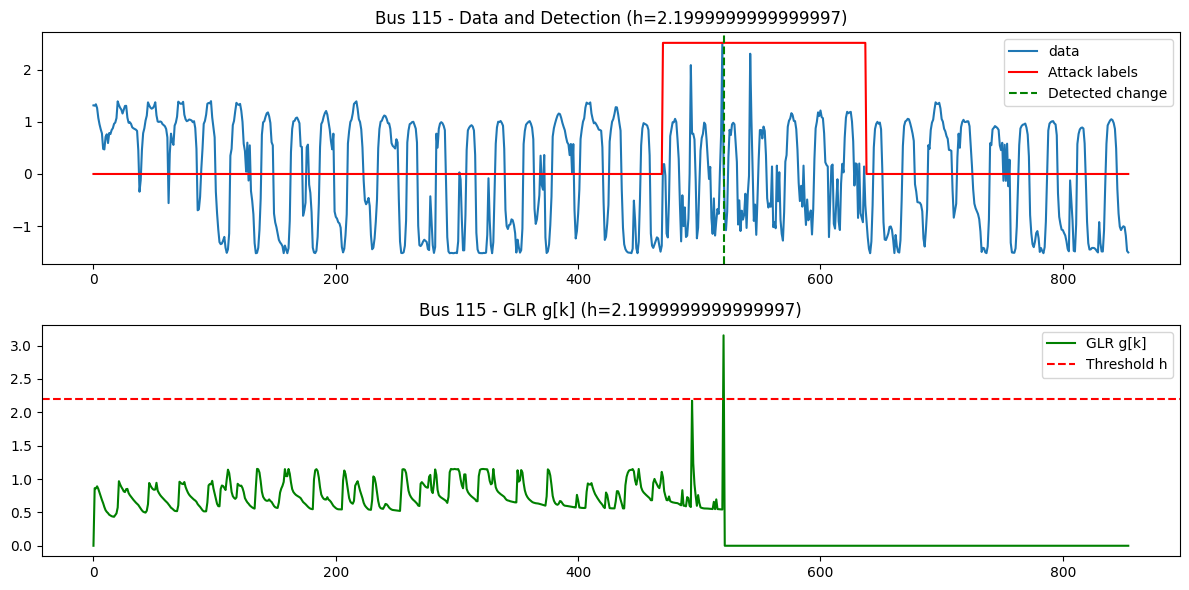

541


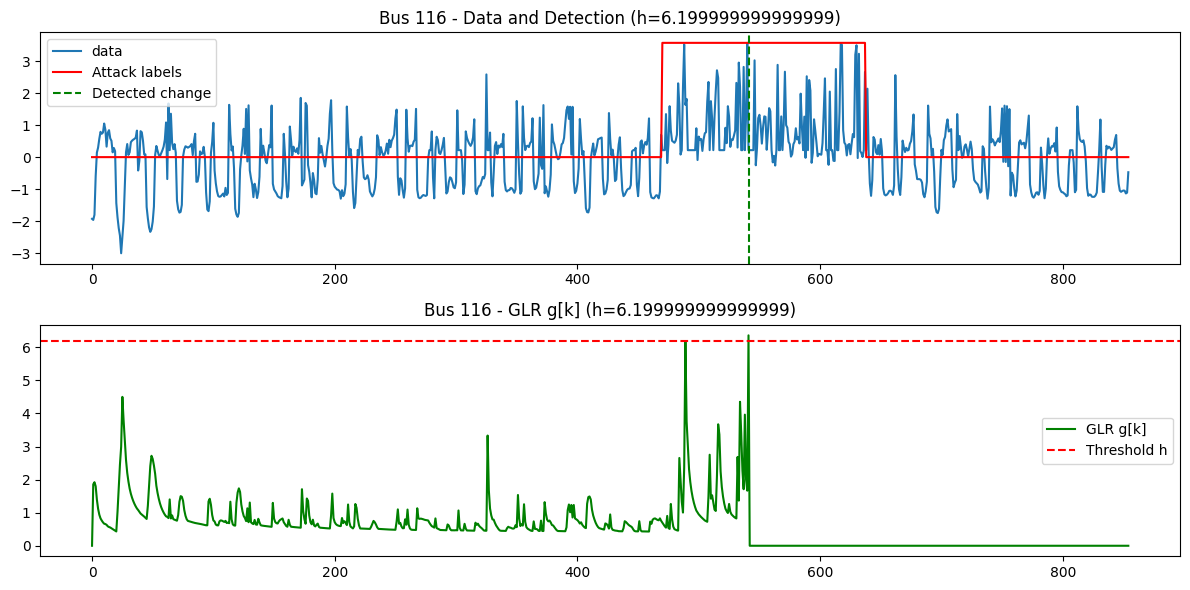

520


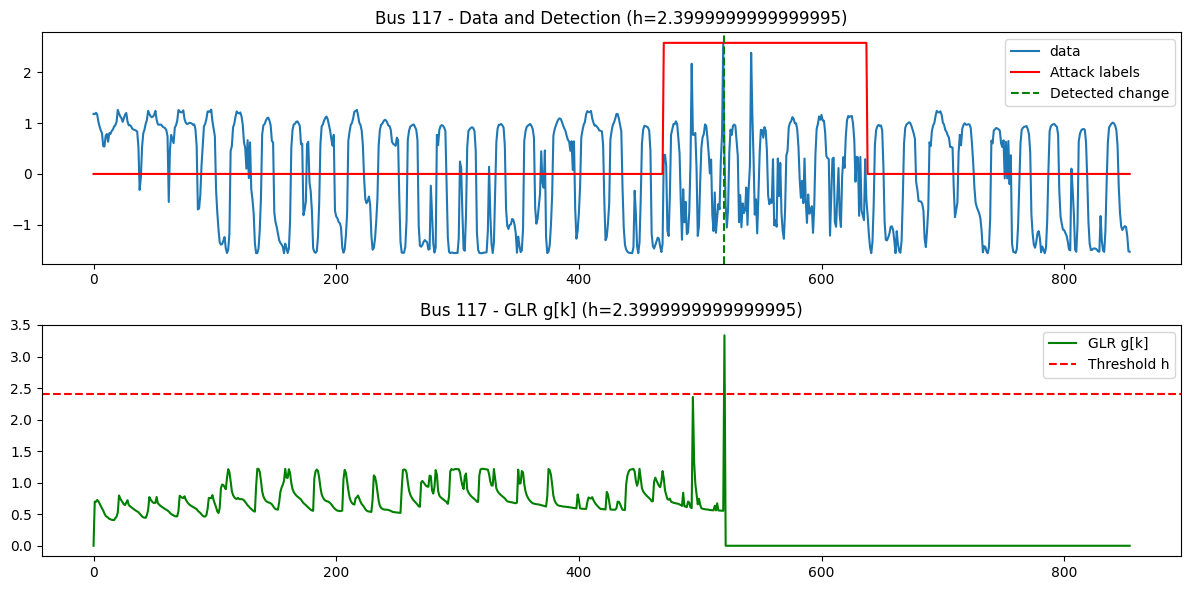

520


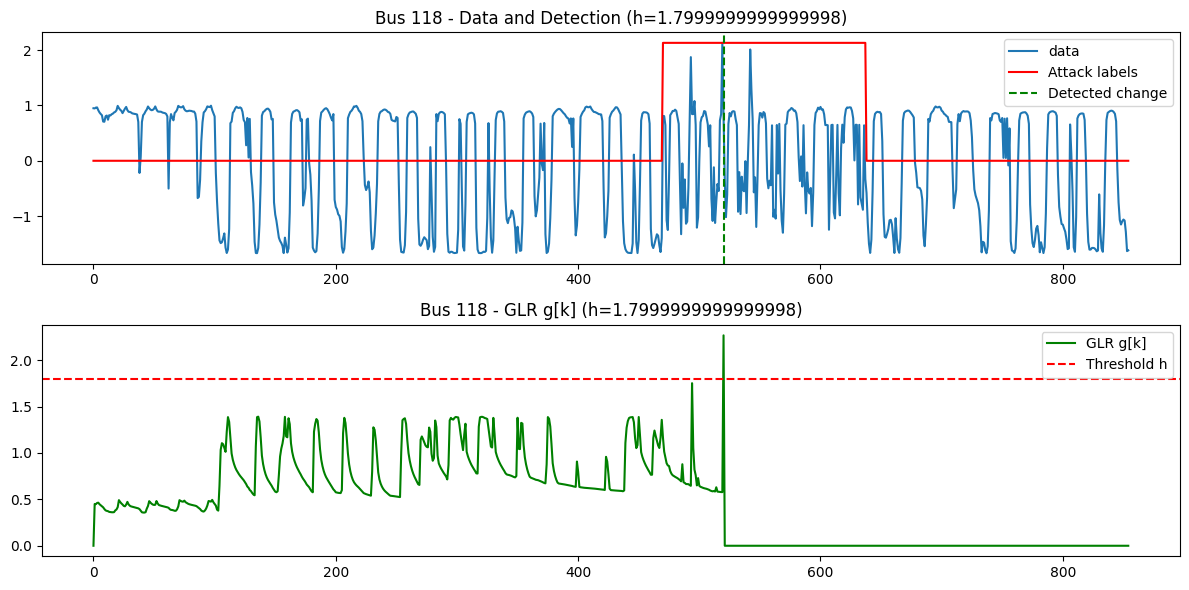

520


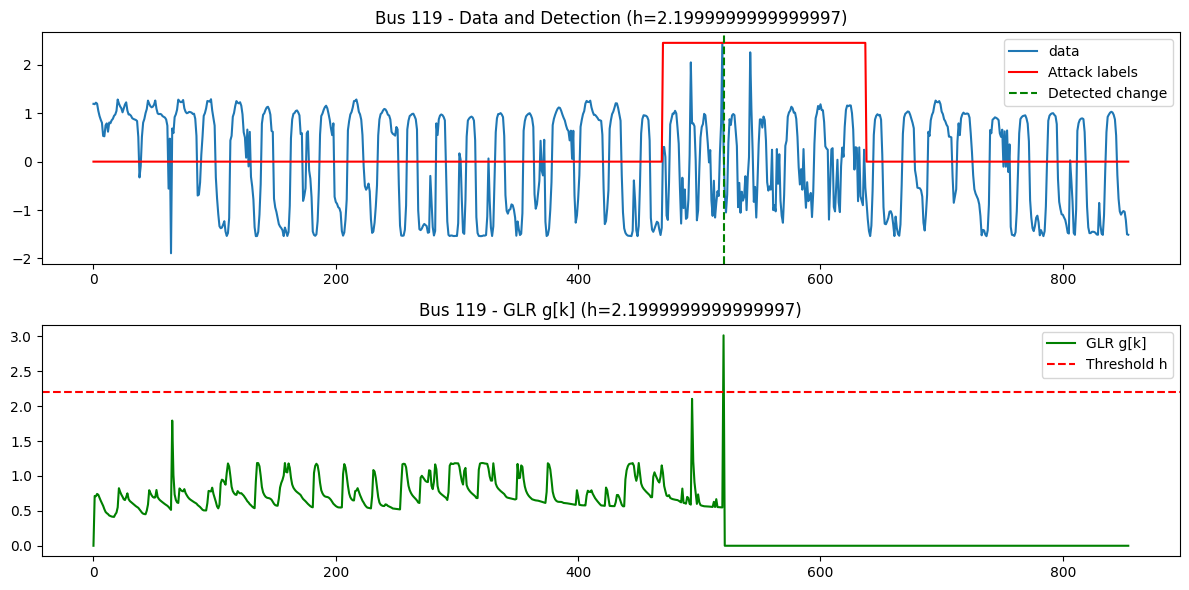

494


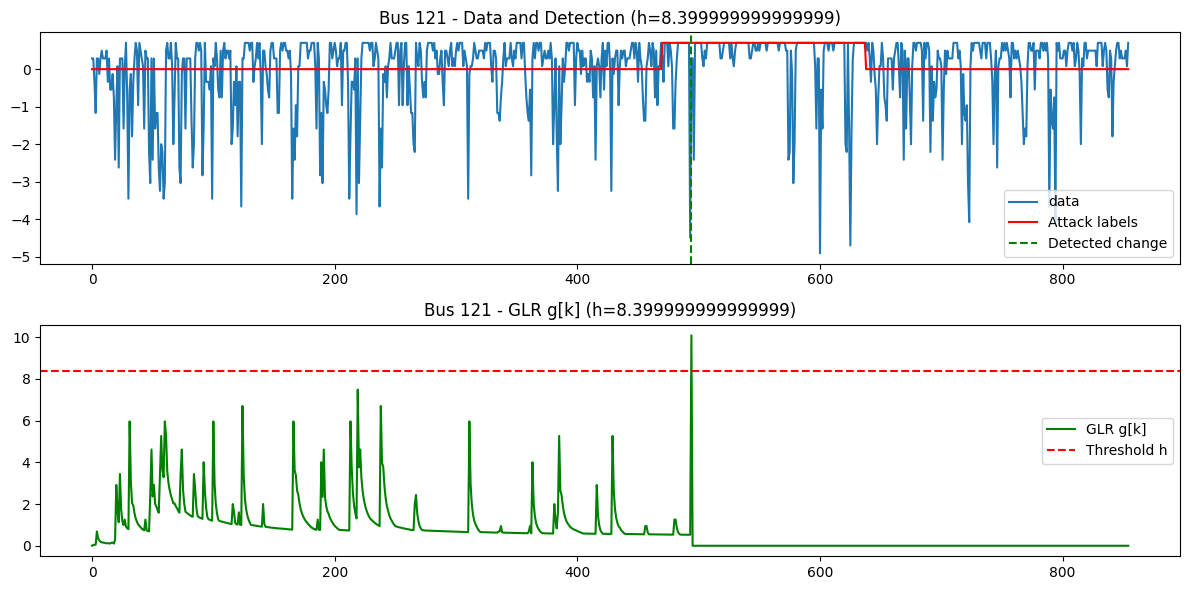

23


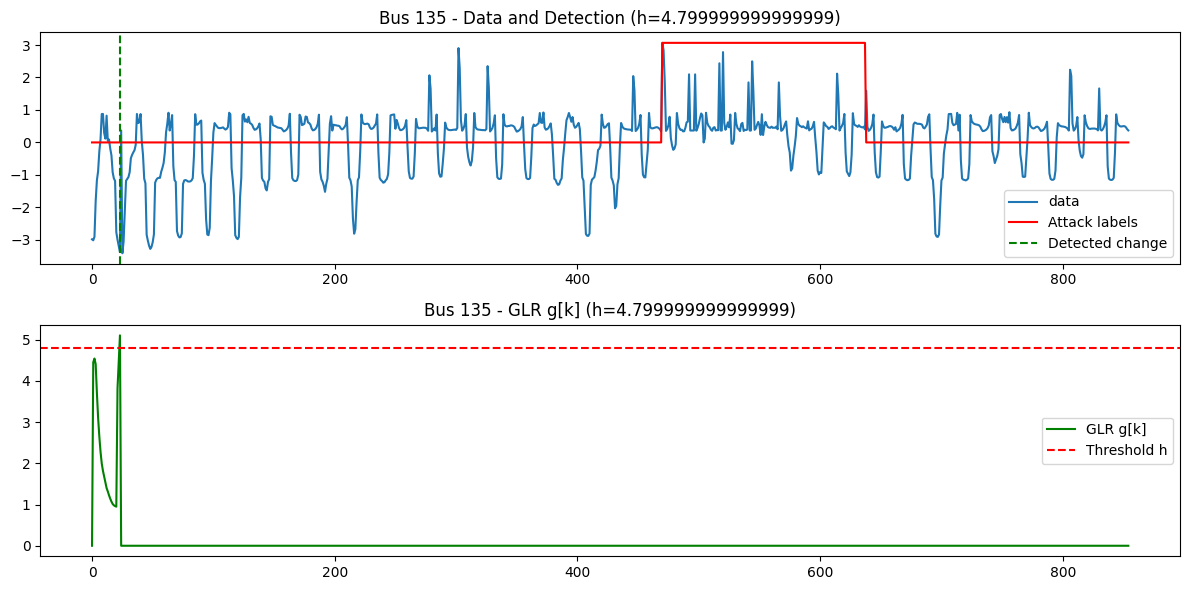

532


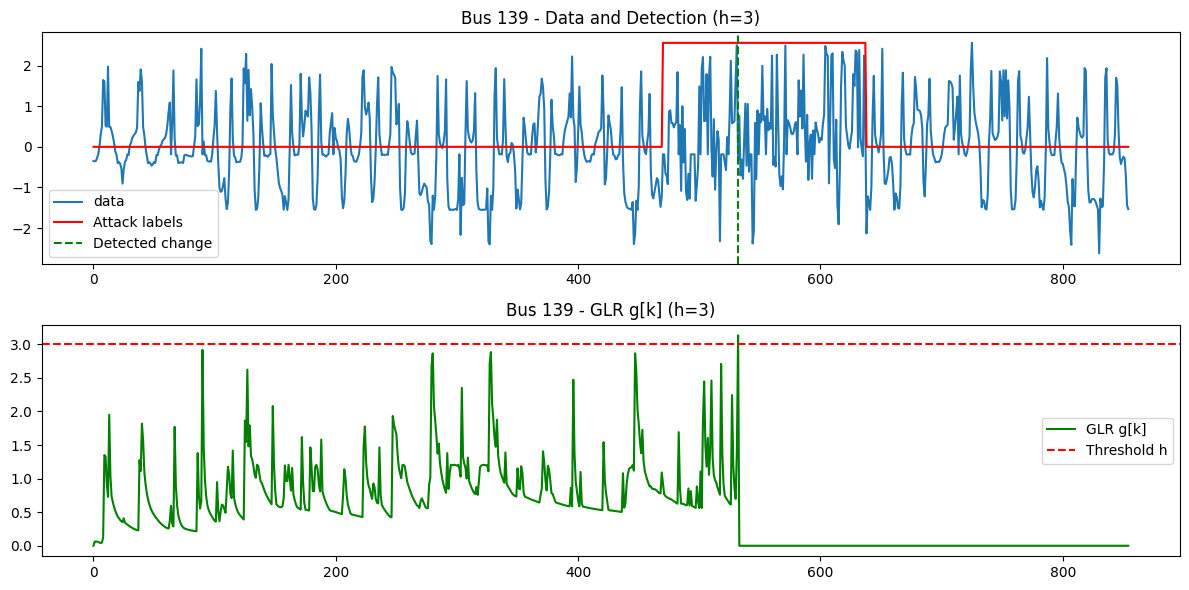

In [ ]:
plot_results(results)

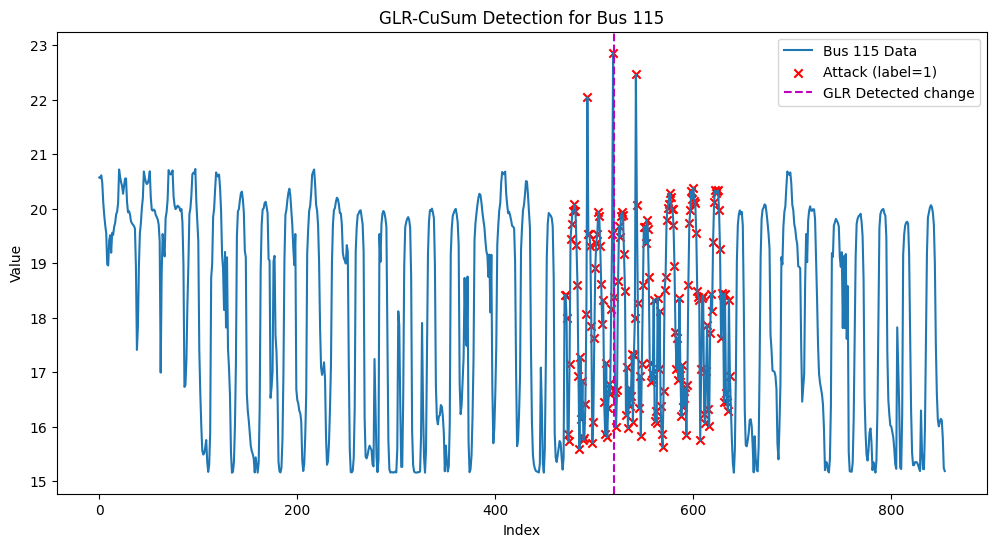

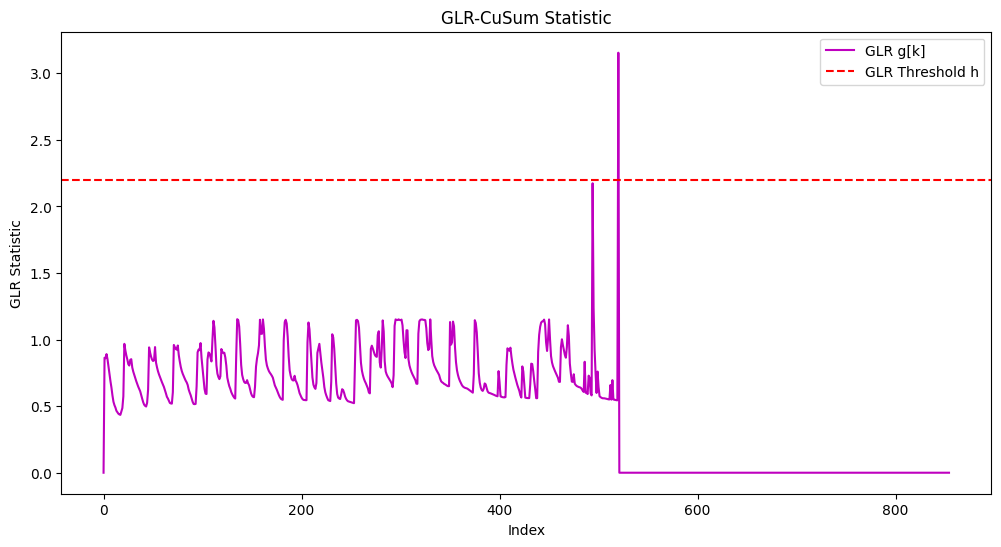

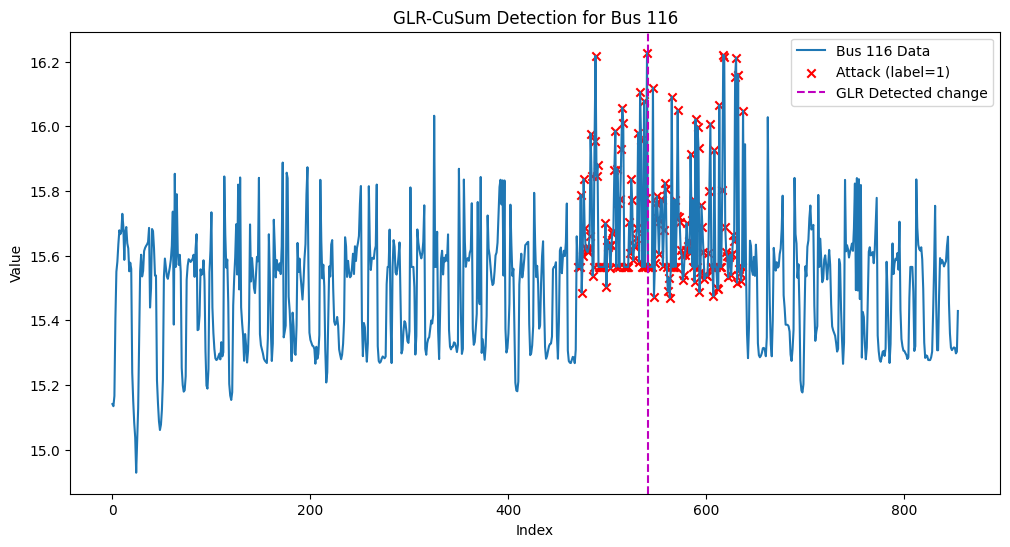

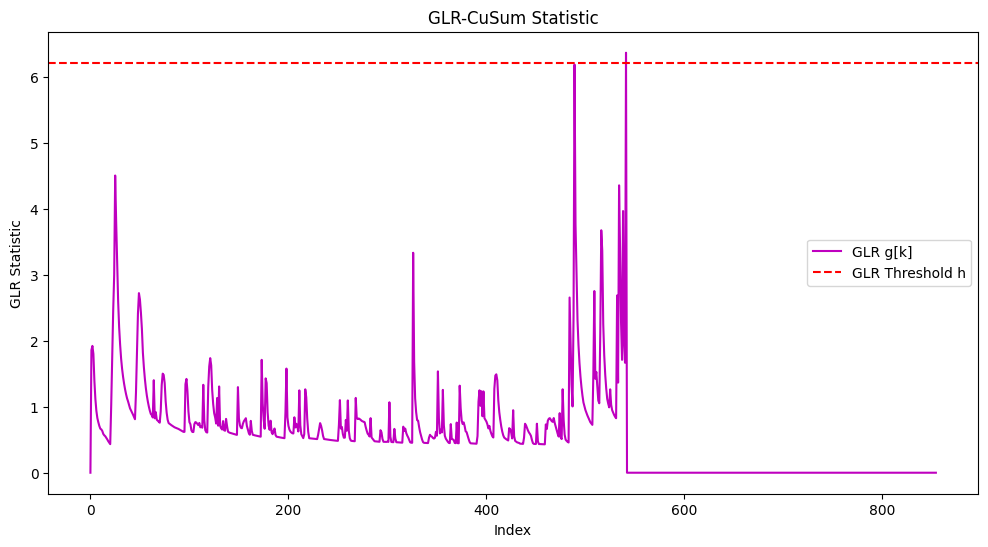

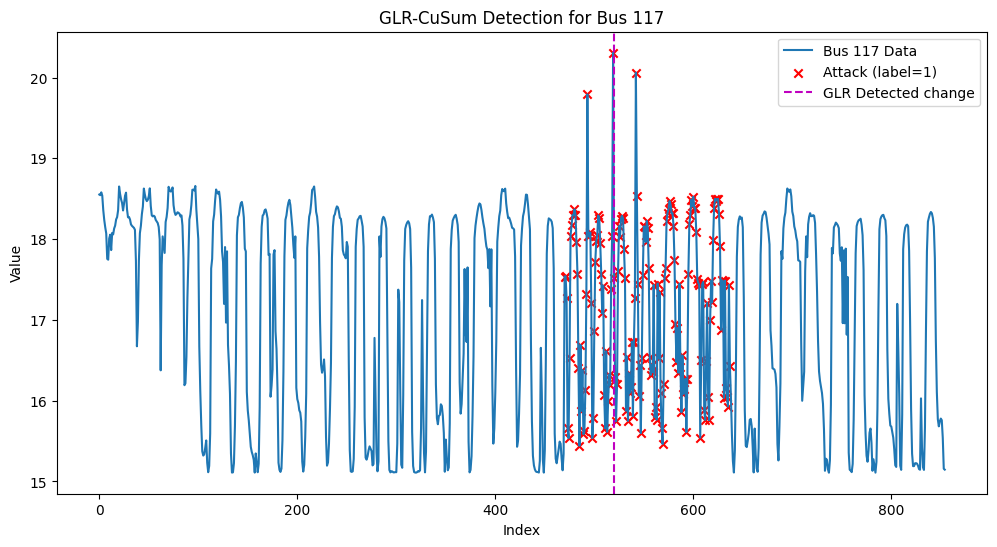

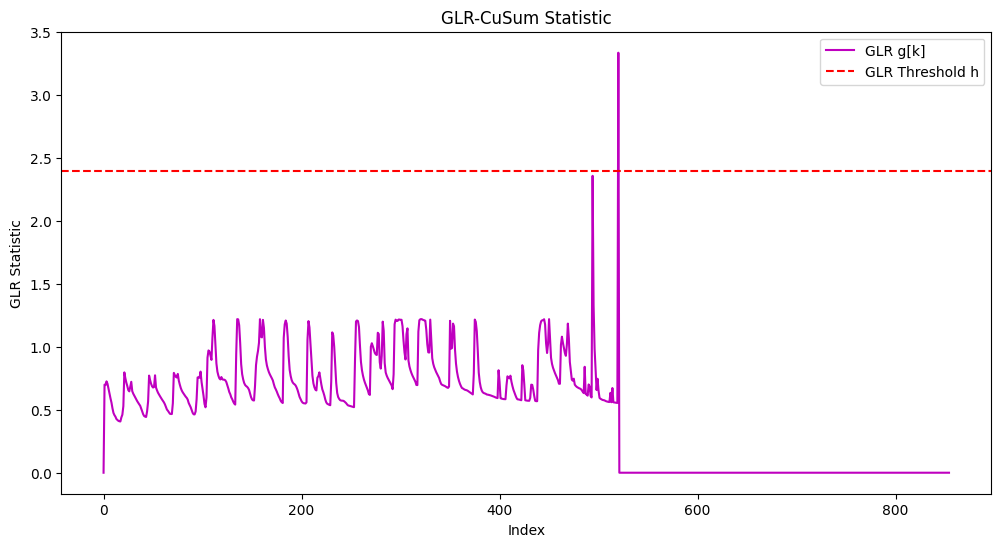

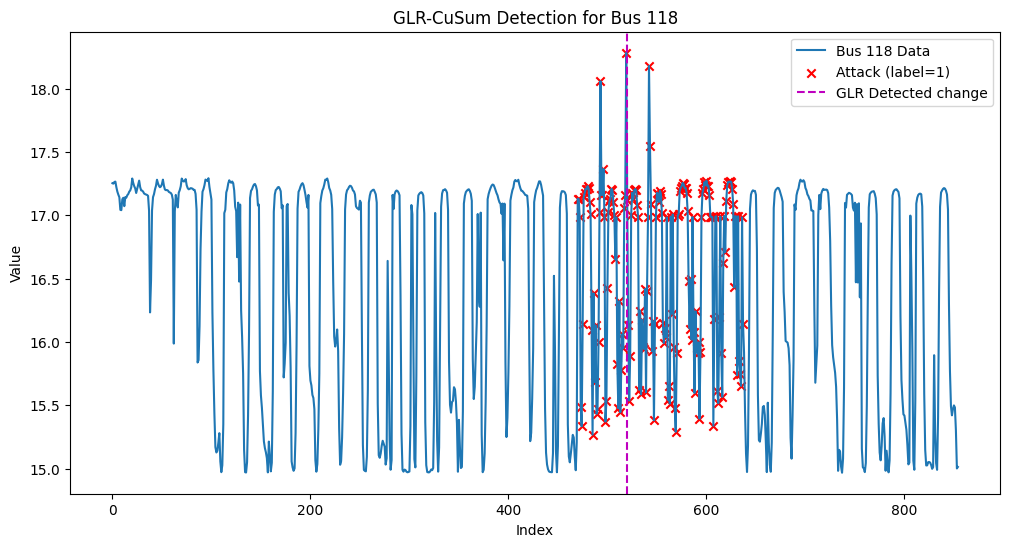

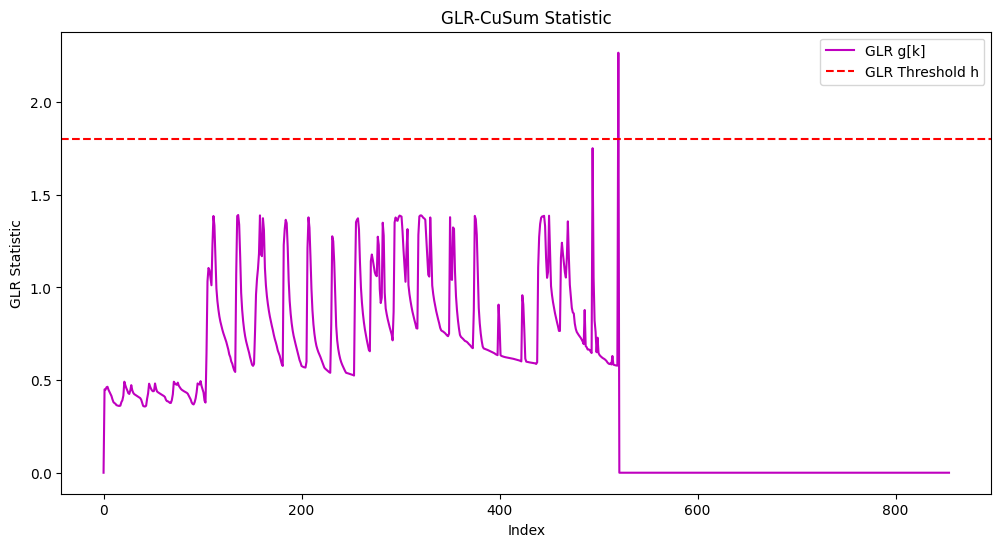

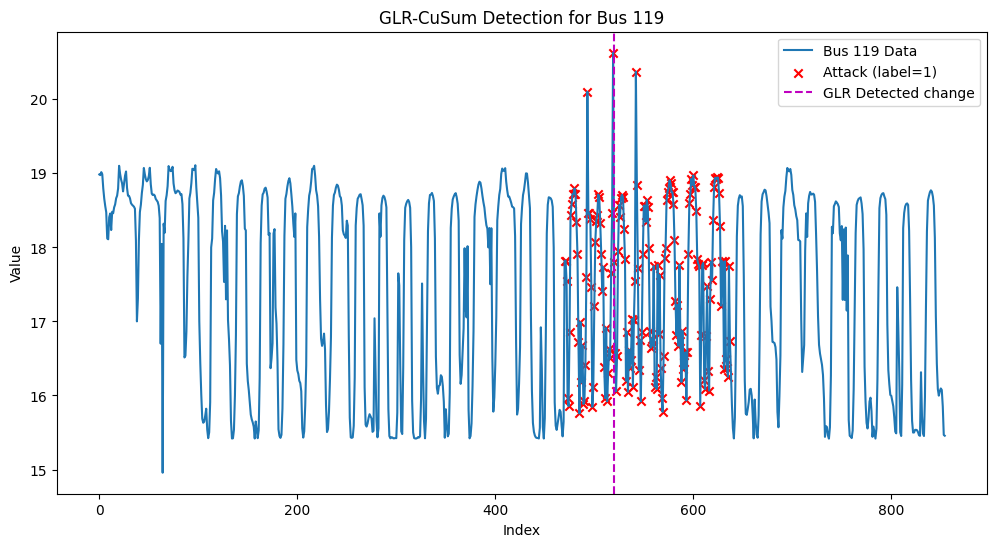

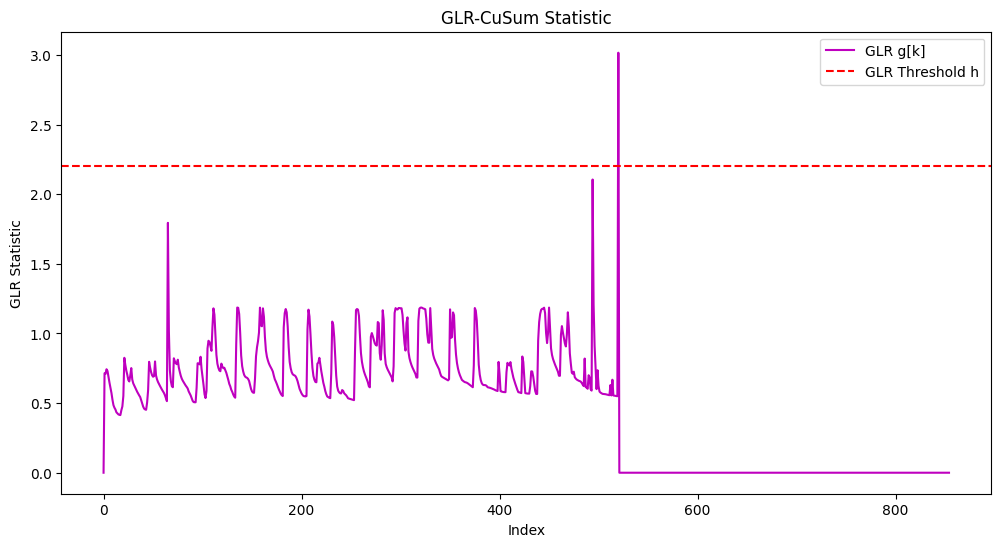

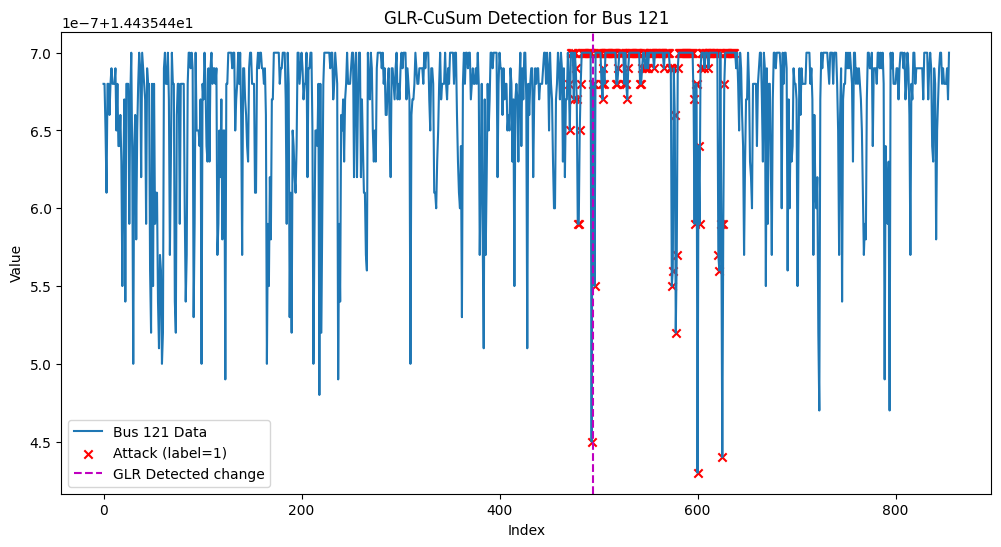

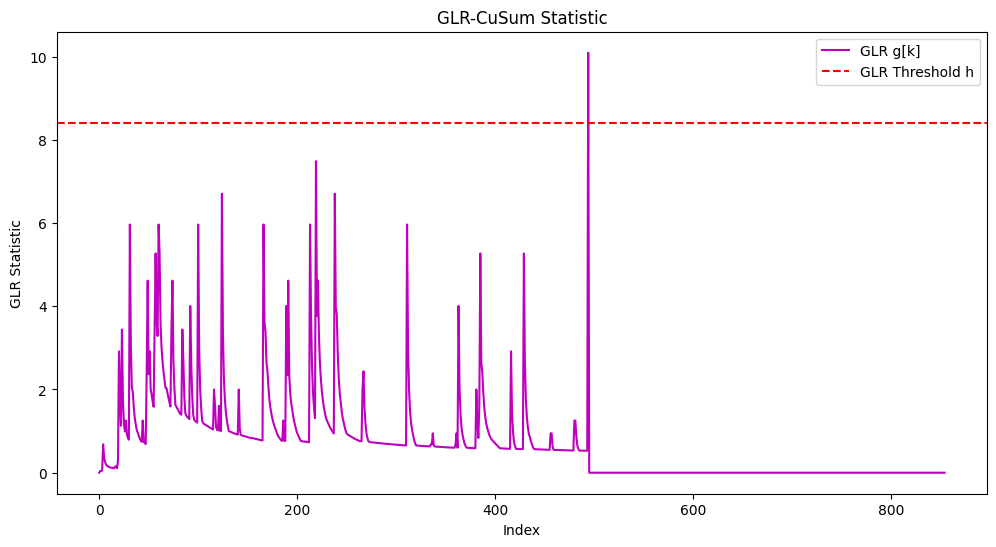

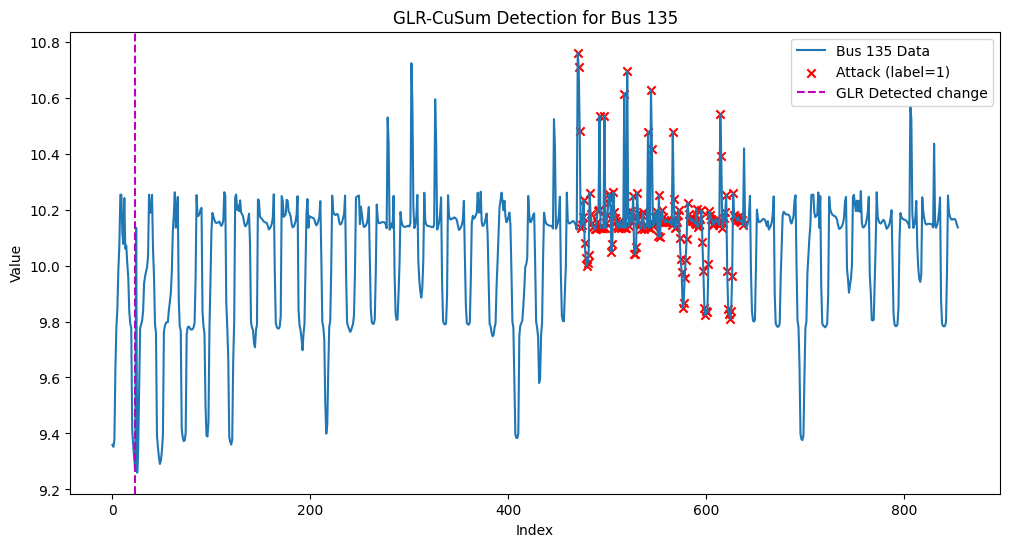

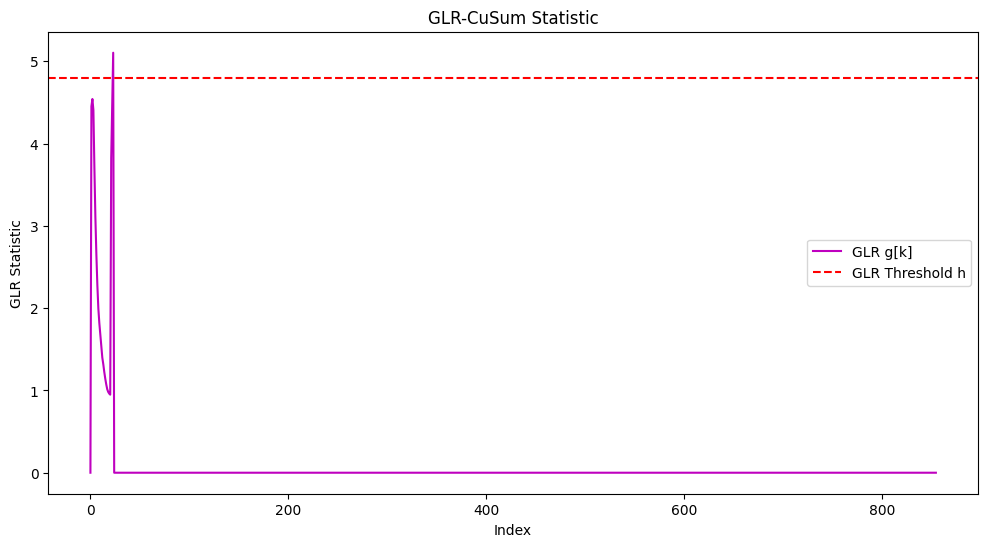

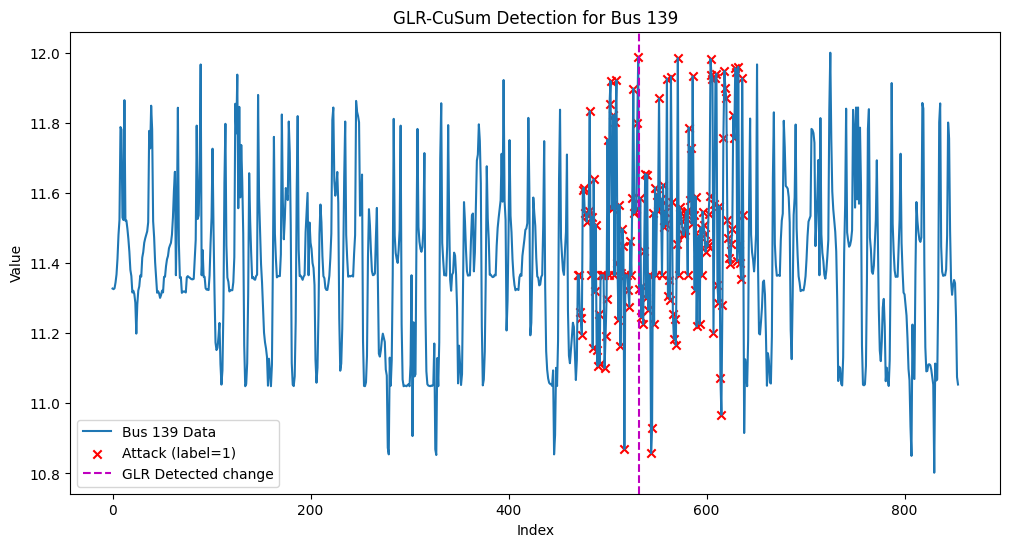

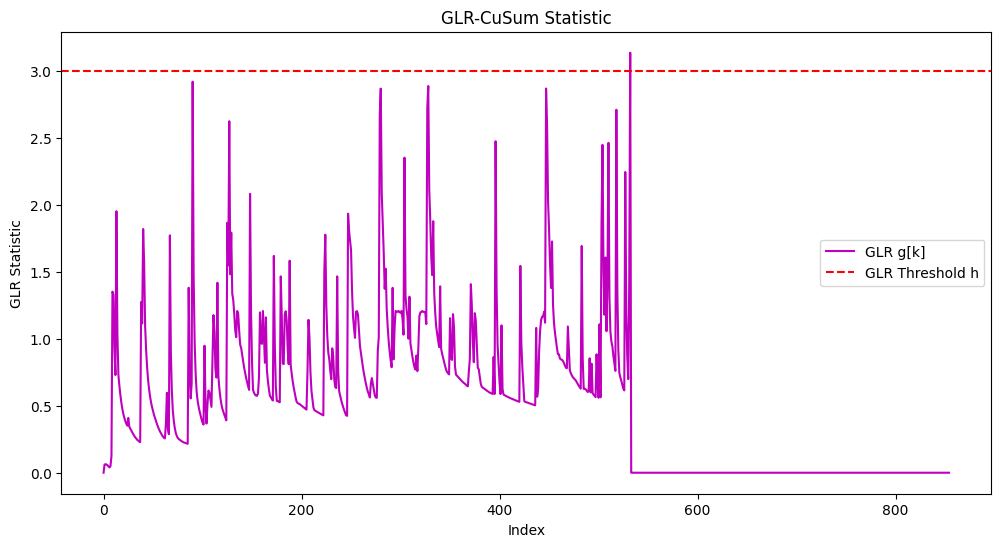

GLR/CuSum Average Detection Delay: 51.0
GLR/CuSum False Alarm Rate: 0.125


In [ ]:
# 设定阈值和sigma0

results = {"delays": [], "false_alarms": 0, "total_cases": 0}
# 应用到每个巴士数据
for bus_number in bus_numbers:
    data = bus_data[bus_number][:, 0]
    labels = bus_data[bus_number][:, 1]
    mu0, sigma0 = calculate_mu0_sigma0(data)
    glr_detection_time, g_k = glr_cusum(data, mu0, sigma0,best_thresholds[bus_number])
    if glr_detection_time < len(data):
        if labels[glr_detection_time] == 1:
            delay = glr_detection_time - np.argmax(labels)
            results["delays"].append(delay)
        else:
            results["false_alarms"] += 1
    results["total_cases"] += 1

    plt.figure(figsize=(12, 6))
    plt.plot(data, label=f'Bus {bus_number} Data')
    attack_indices = np.where(bus_data[bus_number][:, 1] == 1)[0]
    plt.scatter(attack_indices, data[attack_indices], color='r', label='Attack (label=1)', marker='x')
    plt.axvline(glr_detection_time, color='m', linestyle='--', label='GLR Detected change')
    plt.title(f'GLR-CuSum Detection for Bus {bus_number}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(g_k, label='GLR g[k]', color='m')
    plt.axhline(best_thresholds[bus_number], color='r', linestyle='--', label='GLR Threshold h')
    plt.title('GLR-CuSum Statistic')
    plt.xlabel('Index')
    plt.ylabel('GLR Statistic')
    plt.legend()
    plt.show()
average_delay = np.mean(results["delays"])
false_alarm_rate = results["false_alarms"] / results["total_cases"]

print(f"GLR/CuSum Average Detection Delay: {average_delay}")
print(f"GLR/CuSum False Alarm Rate: {false_alarm_rate}")

In [ ]:
# 应用GLR-CuSum算法
results = apply_glr_cusum(bus_data, best_thresholds)

In [ ]:
total_steps = len(next(iter(results.values()))[0])
total_steps

855

In [ ]:
def voting_scheme(results, p_values):
    N = len(results)
    total_steps = len(next(iter(results.values()))[0])
    votes = np.zeros((N, total_steps))

    for i, (bus, (_, labels, detection_time, _, _)) in enumerate(results.items()):
        if detection_time != -1:
            votes[i, detection_time:] = 1

    far_results = {}
    dd_results = {}

    for p in p_values:
        far_list = []
        dd_list = []
        for t in range(total_steps):
            if np.sum(votes[:, t]) >= p * N:
                detected_time = t
                real_change_points = np.where(labels == 1)[0]
                if len(real_change_points) > 0:
                    first_real_change = real_change_points[0]
                    delay = detected_time - first_real_change
                    if delay >= 0:
                        dd_list.append(delay)
                    else:
                        far_list.append(1)
                else:
                    far_list.append(1)
                break
        far_results[p] = np.mean(far_list) if far_list else 0
        dd_results[p] = np.mean(dd_list) if dd_list else 0

    return far_results, dd_results

# p值列表
p_values = [0.1, 0.2,0.3,0.4, 0.5, 0.7, 0.9]

# 计算不同p值下的FAR和DD
far_results, dd_results = voting_scheme(results, p_values)


In [ ]:
def summarize_results(far_results, dd_results):
    print("Voting Scheme Results:")
    print(f"{'p-value':<10} {'FAR':<10} {'DD':<10}")
    for p in far_results.keys():
        print(f"{p:<10} {far_results[p]:<10.4f} {dd_results[p]:<10.4f}")

    best_p = min(far_results, key=far_results.get)
    print(f"\nBest p-value for FAR: {best_p} with FAR: {far_results[best_p]:.4f} and DD: {dd_results[best_p]:.4f}")

    best_p = min(dd_results, key=dd_results.get)
    print(f"Best p-value for DD: {best_p} with DD: {dd_results[best_p]:.4f} and FAR: {far_results[best_p]:.4f}")

summarize_results(far_results, dd_results)


Voting Scheme Results:
p-value    FAR        DD        
0.1        1.0000     0.0000    
0.2        0.0000     24.0000   
0.3        0.0000     50.0000   
0.4        0.0000     50.0000   
0.5        0.0000     50.0000   
0.7        0.0000     50.0000   
0.9        0.0000     71.0000   

Best p-value for FAR: 0.2 with FAR: 0.0000 and DD: 24.0000
Best p-value for DD: 0.1 with DD: 0.0000 and FAR: 1.0000


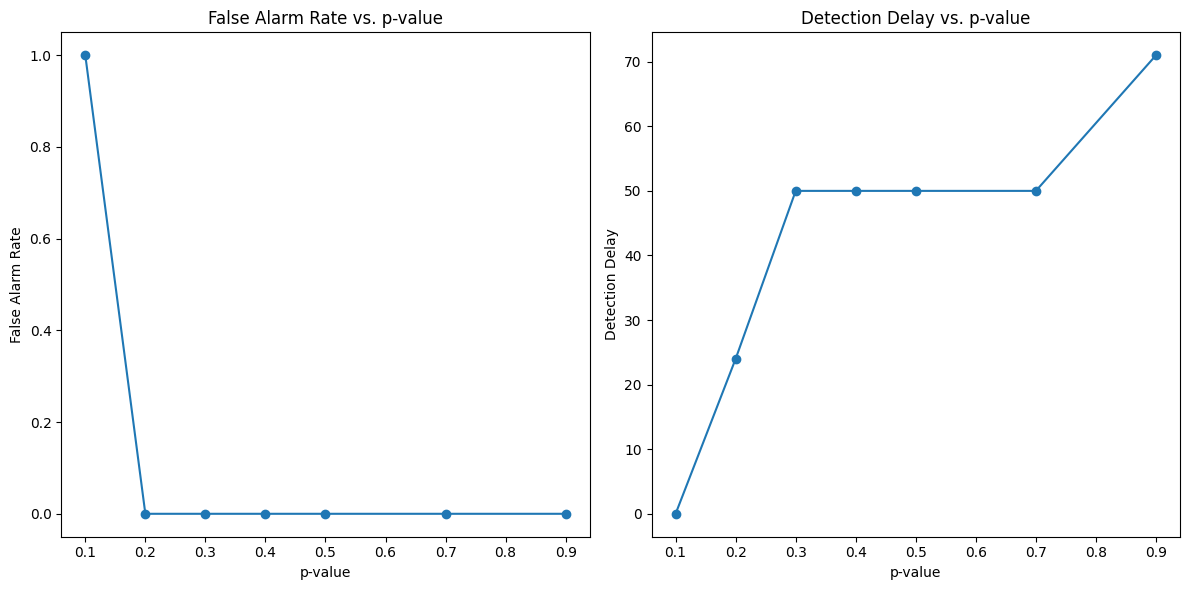

In [ ]:
def plot_voting_results(far_results, dd_results):
    p_values = list(far_results.keys())
    far_values = list(far_results.values())
    dd_values = list(dd_results.values())

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(p_values, far_values, marker='o')
    plt.title('False Alarm Rate vs. p-value')
    plt.xlabel('p-value')
    plt.ylabel('False Alarm Rate')

    plt.subplot(1, 2, 2)
    plt.plot(p_values, dd_values, marker='o')
    plt.title('Detection Delay vs. p-value')
    plt.xlabel('p-value')
    plt.ylabel('Detection Delay')

    plt.tight_layout()
    plt.show()

plot_voting_results(far_results, dd_results)
